### **DLFA Assignment-2 (RNN)**
### **Name : Onkar Sabnis (18CH30018)**

#### *This notebook contains the Sentiment Analysis on the provided IMDB dataset and is been divided into multiple subsections*

In [3]:
### Importing the necessary Libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import nltk
import spacy
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
#!pip install texthero
import texthero as hero
import collections

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
wordlemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Loading Data, Basic Processing, Analyzing the Sentiment and Visualization**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df = pd.read_csv('./gdrive/My Drive/data/IMDB Dataset.csv')   ### Reading the provided IMDB data

In [7]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [8]:
df.describe()
### General statistical description of dataset

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [9]:

df.isnull().sum() 
### No null values

review       0
sentiment    0
dtype: int64

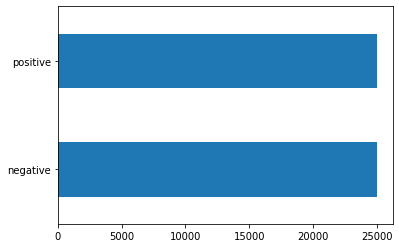

In [10]:

(df['sentiment'].value_counts()).plot.barh()
### Equal no. of positive and Negative sentiment. No imbalance in dataset

In [11]:
df['review'].duplicated().sum()           ### 418 duplicated entries in dataset

418

In [12]:
df_duplicate_entries = df[df['review'].duplicated(keep='first') == True]

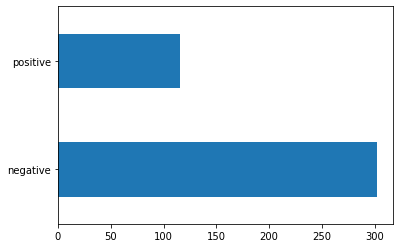

In [13]:
df_duplicate_entries['sentiment'].value_counts().plot.barh()
#### There are more duplicate entries for negative sentiment than positive sentiment

In [14]:
df_modified = df.drop_duplicates(subset=['review'])
df_modified.reset_index(inplace = True)
### df_modified is dataset obtained after removal of duplicate entries

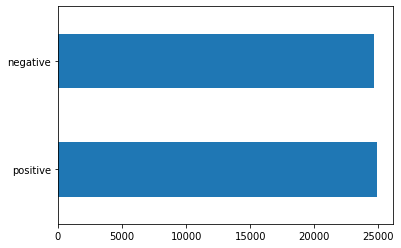

In [15]:
df_modified['sentiment'].value_counts().plot.barh()
#### Negative sentiment entries are slightly less than positive sentiment entries but we can proceed with this as the difference
### is not that big to make the dataset imbalanced

### **Data_PreProcessing (Processing the Reviews)**

In [16]:
### Preprocessing Functions


def lemmatize_words(words):       ###Lemmatizing
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(wordlemmatizer.lemmatize(word))
    return lemmatized_words



def stem_words(words):          ####Stemming
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words



In [17]:
def remove_special_characters(text):          ####Special char removal
    regex = r'[^a-zA-Z0-9\s ]+'
    text = re.sub(regex,'',text)
    return text


def lower(text):
    return text.lower()


### Calculating the frequency of each word in the document
def freq(words):
    words = [word.lower() for word in words]
    dict_freq = {}
    words_unique = []
    for word in words:
        if word not in words_unique:
            words_unique.append(word)
    for word in words_unique:
        dict_freq[word] = words.count(word)
    return dict_freq

stop_words = set(stopwords.words('english'))  


def remove_stopwords(text):
    word_tokens = word_tokenize(text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    return ' '.join(filtered_sentence)

In [18]:
df_modified['review(HTML_tags_removed)'] = hero.remove_html_tags((df_modified['review']))
### Reviews contained some HTML tags which are removed using above code

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
#### Removes all the special characters from the reviews and lowers the text
### Also removes the stopwords from the review (stopwords used are standard english stopwords)

arr = [[] for i in range(len(df_modified))]
m = 0
for i in range(len(df_modified['review(HTML_tags_removed)'])):
    a = sent_tokenize(df_modified['review(HTML_tags_removed)'][i])
    for j in a:  
    arr[m].append(remove_stopwords( remove_special_characters(lower(j))))
    m = m + 1

In [20]:
brr = []
for i in range(len(arr)):
    brr.append('.'.join(arr[i]))

In [21]:
df_modified['Preprocessed_Reviews'] = brr  ### This gives a preprocessed column in our dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### **Creating a word2id Dictionary**

In [35]:
string_list = list(df_modified['Preprocessed_Reviews'])
string = ''
for item in string_list:
    string = string + '.' + item

In [36]:
#### Function to generate a bag of words
# create a list of words
words = string.split()
# Count all the words using Counter Method
count_words = collections.Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [37]:
## vocab to int mapping dictionary
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [38]:
total_words_in_review = []
for i in range(len(sorted_words)):
    total_words_in_review.append(sorted_words[i][0])

In [40]:
top_words_review = total_words_in_review[:20000]   #### Selecing Only top 20000 words

In [44]:
arr_of_split = np.linspace(0,49582,27)

time: 2.06 ms (started: 2021-03-21 13:09:26 +00:00)


### **Tokenization(i.e Encoding words in our reviews by integers)**

In [49]:
### Encoding of reviews (replace words in our reviews by integers)

arre1 = []
#arre2 = []
d = 2
while(d<27):
    arre1 = []
    for review in list(df_modified['Preprocessed_Reviews'][int(arr_of_split[d-1]):int(arr_of_split[d])]):
    for w in review.split():
        if str(w) in top_words_review:
            arre1.append(vocab_to_int[w])
    arre2.append(arre1)
    arre1 = []
    d = d + 1

time: 13min 42s (started: 2021-03-21 13:12:45 +00:00)


In [50]:
len(arre2)

49582

time: 3.57 ms (started: 2021-03-21 13:29:20 +00:00)


In [51]:
reviews_int = arre2

time: 1.11 ms (started: 2021-03-21 13:31:58 +00:00)


In [52]:
###Encoding Labels (i.e Our Target Sentiments)
#### Positive = 0 and Negative = 1 for sentiments

encoded_labels = [1 if label =='positive' else 0 for label in list(df_modified['sentiment'])]
encoded_labels = np.array(encoded_labels)

time: 18.9 ms (started: 2021-03-21 13:32:00 +00:00)


### **Analysis of Review Length**

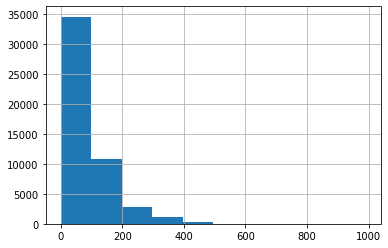

count    49582.000000
mean        92.719213
std         70.826571
min          1.000000
25%         49.000000
50%         69.000000
75%        113.000000
max        989.000000
dtype: float64

time: 256 ms (started: 2021-03-21 13:32:07 +00:00)


In [53]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

 **Observations** : a) Mean review length = 93 b) Some reviews are of 1 length. Keeping this review won’t make any sense for our analysis 
 c) Most of the reviews less than 200 words or more d) There are quite a few reviews that are extremely long, we can manually investigate them to
  check whether we need to include or exclude them from our analysis


In [55]:
###Removing Outliers — Getting rid of extremely long or short reviews
### Remove 0 length reviews
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

time: 23.1 ms (started: 2021-03-21 13:48:50 +00:00)


### **Padding**

In [56]:
### Padding / Truncating the remaining data
seq_length = 100
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

time: 11 ms (started: 2021-03-21 13:48:56 +00:00)


In [59]:
features = pad_features(reviews_int, seq_length=seq_length)
print(features[:10,:10])      # print first 10 values of the first 10 batches 

[[    3  1880   937    63   424  3702   296   333   467   579]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   38    10   186  2101  1280     2 12155  1249    68  3823]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]]
time: 858 ms (started: 2021-03-21 13:50:04 +00:00)


### **Train,Test Split of Data**

In [79]:
split_frac = 0.8
len_feat = len(features)
train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

time: 11.2 ms (started: 2021-03-21 14:12:22 +00:00)


In [80]:
train_x = train_x[:39600]
valid_x = valid_x[:4950]
test_x = test_x[:4950]

time: 1.77 ms (started: 2021-03-21 14:12:24 +00:00)


In [81]:
train_y = train_y[:39600]
valid_y = valid_y[:4950]
test_y = test_y[:4950]

time: 2.4 ms (started: 2021-03-21 14:12:31 +00:00)


In [82]:
## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(valid_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))


			Feature Shapes:
Train set: 		(39600, 100) 
Validation set: 	(4950, 100) 
Test set: 		(4950, 100)
time: 4.31 ms (started: 2021-03-21 14:12:34 +00:00)


### **Batching and loading as tensor (batch size =50)**

In [83]:
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(valid_x)), torch.from_numpy(np.array(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array((test_y))))


# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

time: 36 ms (started: 2021-03-21 14:12:37 +00:00)


In [84]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[    0,     0,     0,  ...,  3942,  3586,  2979],
        [    0,     0,     0,  ...,   426,   119,  2516],
        [    0,     0,     0,  ...,   917,    15,  1064],
        ...,
        [   23,   267,    46,  ...,  3417,  2419, 11184],
        [    0,     0,     0,  ...,    36,    98,    10],
        [ 2003,    17,   978,  ...,    77,     8,   291]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0])
time: 19.3 ms (started: 2021-03-21 14:12:45 +00:00)


In [ ]:
# Here, 50 is the batch size and 100 is the sequence length that we have defined. Now our data prep step is complete and next 
# we will look at the LSTM network architecture for start building our model.

In [85]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()
if(train_on_gpu):
  print('Training on GPU.')
else:
  print('No GPU available, training on CPU.')

No GPU available, training on CPU.
time: 4.04 ms (started: 2021-03-21 14:13:05 +00:00)


### **Model Designing (LSTM architecture)**

In [86]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

time: 57.3 ms (started: 2021-03-21 14:13:08 +00:00)


In [87]:
# Instantiate the model w/ hyperparams
vocab_size = len(top_words_review)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(20001, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
time: 127 ms (started: 2021-03-21 14:13:14 +00:00)


In [88]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()   ###Binary Cross Entropy Loss Function
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

time: 8.06 ms (started: 2021-03-21 14:13:18 +00:00)


### **Training**

In [89]:
# training params

epochs = 4        # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5       # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.639396... Val Loss: 0.616795
Epoch: 1/4... Step: 200... Loss: 0.635035... Val Loss: 0.608087
Epoch: 1/4... Step: 300... Loss: 0.575148... Val Loss: 0.639320
Epoch: 1/4... Step: 400... Loss: 0.693257... Val Loss: 0.648894
Epoch: 1/4... Step: 500... Loss: 0.661227... Val Loss: 0.662558
Epoch: 1/4... Step: 600... Loss: 0.693952... Val Loss: 0.661903
Epoch: 1/4... Step: 700... Loss: 0.650615... Val Loss: 0.584691
Epoch: 2/4... Step: 800... Loss: 0.386591... Val Loss: 0.501767
Epoch: 2/4... Step: 900... Loss: 0.413901... Val Loss: 0.484918
Epoch: 2/4... Step: 1000... Loss: 0.565341... Val Loss: 0.433561
Epoch: 2/4... Step: 1100... Loss: 0.362952... Val Loss: 0.410579
Epoch: 2/4... Step: 1200... Loss: 0.371103... Val Loss: 0.410274
Epoch: 2/4... Step: 1300... Loss: 0.279257... Val Loss: 0.420763
Epoch: 2/4... Step: 1400... Loss: 0.436639... Val Loss: 0.390046
Epoch: 2/4... Step: 1500... Loss: 0.350240... Val Loss: 0.386693
Epoch: 3/4... Step: 1600... Loss: 

### **Test Data Loss and Accuracy**

In [90]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.410
Test accuracy: 0.839
time: 27.8 s (started: 2021-03-21 15:17:18 +00:00)
